# Caracterização de eletrofáceis por meio de inteligência artificial com abordagem supervisionada
## Treinamento teste e análise do modelo

- **Nome do Arquivo**: treinamento_modelo.ipynb
- **Autor**: Rafael Takeguma Goto
- **Versão**: 1.0
- **Data de Criação**: 24/06/2024
- **Data de Modificação**: 20/07/2024

### Descrição: 
Este notebook contém a etapa do trabalho referente à realização do treinamento, teste e análise do algoritmo de identificação de eletrofáceis a partir dos dados rotulados.

### Leitura do conjunto de dados
O conjunto de dados é constituído por um arquivo csv, que é resultado da concatenação dos arquivos csv gerados a partir da fusão da extração dos arquivos dlis com os arquivos agp de cada poço, seguida da aplicação dos seguintes processamentos:
- filtros de constantes 
- filtros de nulos
- filtros de perfis (DCAL e DRHO)
- reclassificação da litologia metamórfica

In [1]:
import pandas as pd

path_pocos_pre_transicao = 'Dados-filtrados-concatenados\pocos_pre_transicao_v2.csv'

dados_concatenados_leitura = pd.read_csv(path_pocos_pre_transicao)

dados_concatenados = pd.DataFrame(dados_concatenados_leitura)

## Dados sem balanceamento e sem unidades geológicas
### Divide os dados em treinamento e teste
Divide os dados armazenados em dados_concatenados em 2/3 para treinamento do modelo, e 1/3 para teste do modelo.

In [2]:
from sklearn.model_selection import train_test_split

# Define as variáveis que serão utilizadas (propriedades de perfis) 
propriedades = ['GR', 'DCAL', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE']

# Separa as variáveis (propriedades de perfis) e armazena em X
X = dados_concatenados[propriedades]

# Separa a variável alvo (litologia) e armazena em y
y = dados_concatenados['Litologia']

# Divide os dados em 2/3 para treinamento e 1/3 para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

### Verifica quantidade total de amostras por litologia

In [3]:
# armazena as diferentes litologias existentes na variável 'litologias'
litologias = dados_concatenados['Litologia'].unique()

for litologia in litologias:
    qtde_litologia = len(dados_concatenados[dados_concatenados['Litologia'] == litologia])
    print(f'{litologia}: {qtde_litologia} registros')

CALCILUTITO: 6302 registros
ARENITO: 8508 registros
FOLHELHO: 15859 registros
ANIDRITA: 1262 registros
SILTITO: 516 registros
CONGLOMERADO: 892 registros
XISTO: 1125 registros
CALCARENITO: 1828 registros
DOLOMITO: 361 registros
GRANITO: 445 registros
FILITO: 202 registros


### Verifica quantidade de amostras para treinamento por litologia

In [4]:
litologia_train_set = pd.DataFrame(y_train)

for litologia in litologias:
    qtde_litologia = len(litologia_train_set[litologia_train_set['Litologia'] == litologia])
    print(f'{litologia}: {qtde_litologia} registros')


CALCILUTITO: 4117 registros
ARENITO: 5720 registros
FOLHELHO: 10595 registros
ANIDRITA: 849 registros
SILTITO: 337 registros
CONGLOMERADO: 575 registros
XISTO: 756 registros
CALCARENITO: 1246 registros
DOLOMITO: 245 registros
GRANITO: 289 registros
FILITO: 137 registros


### Treinamento e teste do modelo
Utiliza os dados de treinamento armazenados em X_train e y_train para treinar o modelo de classificação. De forma semelhante, utiliza os dados de teste armazenados em X_test e y_test para testar a acurácia do modelo.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Treina o modelo
modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)

# Faz previsões com o modelo
y_pred = modelo.predict(X_test)

# Calcula a acuracia
acuracia = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {acuracia:2f}")

Acurácia do modelo: 0.848078


### Matriz de Confusão

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Função para criar a matriz de confusão
def cria_matriz_confusao(matriz_confusao, modelo):
    """
    Cria (plota) matriz de confusão

    Args:
        matriz_confusao (numpy.ndarray): matriz de confusão criada a partir de confusion_matrix().
        modelo (sklearn.ensemble._forest.RandomForestClassifier): modelo RandomForestClassifier()
    """

    # Normaliza a matriz de confusão por linha
    matriz_confusao_normalizada = matriz_confusao.astype('float') / matriz_confusao.sum(axis=1)[:, np.newaxis]
    
    # Rótulos das litologias
    categorias = modelo.classes_

    # Cria strings com os valores absolutos e porcentagem de cada célula da matriz
    num_absoluto_porcentagem = np.empty_like(matriz_confusao, dtype=object)
    for i in range(matriz_confusao.shape[0]):
        for j in range(matriz_confusao.shape[1]):
            num_absoluto_porcentagem[i, j] = f'{matriz_confusao[i, j]}\n{matriz_confusao_normalizada[i, j]:.1%}'
    
    # Tamanho da figura
    plt.figure(figsize=(12,8))
    
    # Objeto dos eixos
    ax = plt.gca()
    
    # Remove traços dos eixos
    ax.tick_params(axis='x', which='both', bottom=False, top=False)  
    ax.tick_params(axis='y', which='both', left=False, right=False)
    
    sns.heatmap(matriz_confusao_normalizada, 
                annot=num_absoluto_porcentagem, 
                fmt='',
                cmap='BuGn', 
                xticklabels=categorias, 
                yticklabels=categorias,
                cbar_kws={'label': 'Proporção da Litologia'},
                annot_kws={"size": 12},
                linewidths=0.7,
                linecolor='gray')
    
    # Rótulos dos eixos
    plt.xlabel('Predito', fontsize=12)
    plt.ylabel('Verdadeiro', fontsize=12)
    
    plt.show()

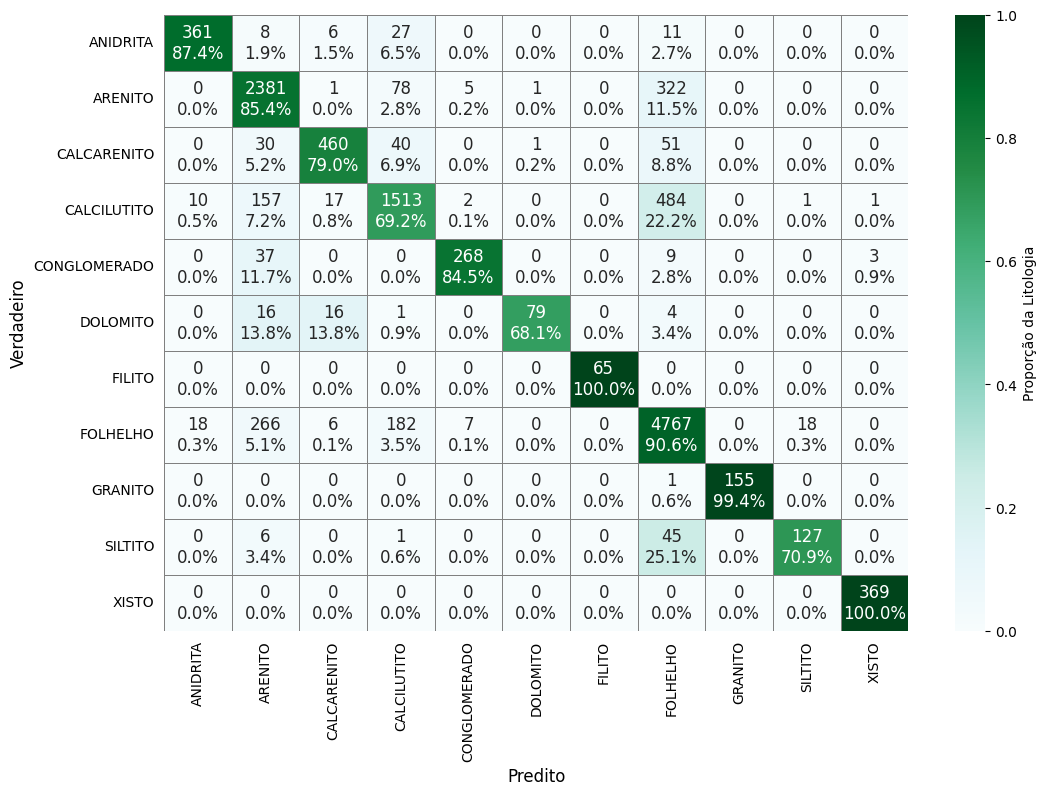

In [7]:
# Cria a matriz de confusão (numpy.ndarray)
matriz_confusao = confusion_matrix(y_test, y_pred)

cria_matriz_confusao(matriz_confusao, modelo)

## Dados sem balanceamento e com unidades geológicas
### Transforma valores categóricos das unidades em inteiros
Transforma os valores das unidades geológicas, contidos na coluna UnidadeF e UnidadeM, em valores inteiros

In [8]:
# Separa todas as unidades presentes nos dados
unidadeF_unicos = dados_concatenados['UnidadeF'].unique()
unidadeM_unicos = dados_concatenados['UnidadeM'].unique()

In [9]:
# Cria mapeamento para os valores únicos em UnidadeF e UnidadeM
unidadeF_mapeamento = {value: index for index, value in enumerate(unidadeF_unicos)}
unidadeM_mapeamento = {value: index for index, value in enumerate(unidadeM_unicos)}

In [10]:
# Aplica o mapeamento ao DataFrame dados_concatenados
dados_concatenados['UnidadeF_num'] = dados_concatenados['UnidadeF'].map(unidadeF_mapeamento)
dados_concatenados['UnidadeM_num'] = dados_concatenados['UnidadeM'].map(unidadeM_mapeamento)

### Divide os dados em treinamento e teste
Divide os dados armazenados em dados_concatenados em 2/3 para treinamento do modelo, e 1/3 para teste do modelo.

In [11]:
# Define as variáveis que serão utilizadas (propriedades de perfis e unidades geológicas) 
propriedades_unidades_geologicas = ['GR', 'DCAL', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE', 'UnidadeF_num', 'UnidadeM_num']

# Separa as variáveis (propriedades de perfis, UnidadeF e UnidadeM) e armazena em X_02
X_02 = dados_concatenados[propriedades_unidades_geologicas]

# Separa a variável alvo (litologia) e armazena em y_01
y_02 = dados_concatenados['Litologia']

# Divide os dados em 2/3 para treinamento e 1/3 para teste
X_02_train, X_02_test, y_02_train, y_02_test = train_test_split(X_02, y_02, test_size=1/3, random_state=42)

### Treinamento e teste do modelo
Utiliza os dados de treinamento armazenados em X_train e y_train para treinar o modelo de classificação. De forma semelhante, utiliza os dados de teste armazenados em X_test e y_test para testar a acurácia do modelo.

In [13]:
# Treina o modelo
modelo_02 = RandomForestClassifier()
modelo_02.fit(X_02_train, y_02_train)

# Faz previsões com o modelo
y_02_pred = modelo_02.predict(X_02_test)

# Calcula a acuracia
acuracia_02 = accuracy_score(y_02_test, y_02_pred)
print(f"Acurácia do modelo: {acuracia_02:2f}")

Acurácia do modelo: 0.869390
